In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.stats import ttest_ind
import statsmodels.api as sm

In [2]:
df1 = pd.read_csv('/Users/nandipatioohasripriya/Downloads/QVI_purchase_behaviour.csv', header= 0,
                     index_col= False)
df2 = pd.read_excel('/Users/nandipatioohasripriya/Downloads/QVI_transaction_data.xlsx', header= 0,
                     index_col= False)

In [3]:
df1.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [4]:
df2.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [5]:
#merging the data using inner join
df = pd.merge(df1 , df2 , on = 'LYLTY_CARD_NBR' , how = 'inner')

In [6]:
df.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,1000,YOUNG SINGLES/COUPLES,Premium,43390,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,1002,YOUNG SINGLES/COUPLES,Mainstream,43359,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7
2,1003,YOUNG FAMILIES,Budget,43531,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6
3,1003,YOUNG FAMILIES,Budget,43532,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0
4,1004,OLDER SINGLES/COUPLES,Mainstream,43406,1,5,96,WW Original Stacked Chips 160g,1,1.9


In [7]:
#no null values
df.isnull().sum()

LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
DATE                0
STORE_NBR           0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
dtype: int64

In [8]:
df['PROD_NAME'].describe()

count                                     264836
unique                                       114
top       Kettle Mozzarella   Basil & Pesto 175g
freq                                        3304
Name: PROD_NAME, dtype: object

In [9]:
df['CLEANED_PROD_NAME'] = df['PROD_NAME'].apply(lambda x: re.sub(r'\d+', '', x))

# Step 2: Remove trailing 'g'
df['CLEANED_PROD_NAME'] = df['CLEANED_PROD_NAME'].str.replace(r'\sg$', '', regex=True)

# Step 3: Remove extra spaces
df['CLEANED_PROD_NAME'] = df['CLEANED_PROD_NAME'].str.strip()

# Step 4: Get the frequency of each cleaned product name
prod_name_counts = df['CLEANED_PROD_NAME'].value_counts()

# Step 5: Display the sorted product names by frequency
for product, count in prod_name_counts.items():
    print(f"{product}: {count}")

Kettle Mozzarella   Basil & Pesto: 3304
Kettle Tortilla ChpsHny&Jlpno Chili: 3296
Cobs Popd Swt/Chlli &Sr/Cream Chips: 3269
Tyrrells Crisps     Ched & Chives: 3268
Cobs Popd Sea Salt  Chips: 3265
Kettle g Swt Pot Sea Salt: 3257
Tostitos Splash Of  Lime: 3252
Infuzions Thai SweetChili PotatoMix: 3242
Smiths Crnkle Chip  Orgnl Big Bag: 3233
Thins Potato Chips  Hot & Spicy: 3229
Kettle Sensations   Camembert & Fig: 3219
Doritos Corn Chips  Cheese Supreme: 3217
Pringles Barbeque: 3210
Doritos Corn Chip Mexican Jalapeno: 3204
Kettle Sweet Chilli And Sour Cream: 3200
Smiths Crinkle Chips Salt & Vinegar: 3197
Thins Chips Light&  Tangy: 3188
Dorito Corn Chp     Supreme: 3185
Pringles Sweet&Spcy BBQ: 3177
Tyrrells Crisps     Lightly Salted: 3174
Infuzions BBQ Rib   Prawn Crackers: 3174
Kettle Sea Salt     And Vinegar: 3173
Doritos Corn Chip Southern Chicken: 3172
Twisties Chickeng: 3170
Twisties Cheese     Burger: 3169
Grain Waves         Sweet Chilli: 3167
Pringles SourCream  Onion: 3162
Dorit

In [10]:
df = df.drop(['CLEANED_PROD_NAME'] , axis = 1)

In [11]:
#we are going to delete the rows with Woolworths Mild     Salsa 300g & Old El Paso Salsa   Dip Tomato Mild 300g
df.drop(df[df['PROD_NAME'].isin(['Old El Paso Salsa   Dip Tomato Mild 300g', 'Woolworths Mild     Salsa 300g'])].index, axis=0, inplace=True)


In [12]:
print(df['TOT_SALES'].describe())

count    260260.000000
mean          7.300955
std           3.074389
min           1.500000
25%           5.400000
50%           7.400000
75%           8.800000
max         650.000000
Name: TOT_SALES, dtype: float64


In [13]:
#finding a outlier
outliers=[]
def detect_outliers(data):
    
    threshold=9
    mean = np.mean(data)
    std =np.std(data)
    
    
    for i in data:
        z_score= (i - mean)/std 
        if np.abs(z_score) > threshold:
            outliers.append(i)
    return outliers

In [14]:
outlier_pt=detect_outliers(df['TOT_SALES'])

In [15]:
outlier_pt 

[650.0, 650.0]

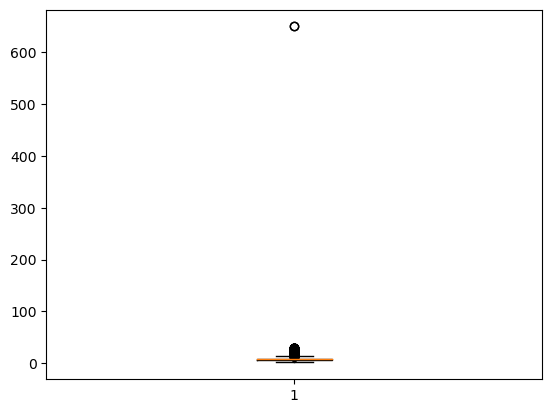

In [16]:
#boxplot 
plt.boxplot(df['TOT_SALES'])
plt.show()

In [17]:
df[df['TOT_SALES'] == 650] #since the prod_qty is high the sales are high these are not outliers.

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
221625,226000,OLDER FAMILIES,Premium,43331,226,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
221626,226000,OLDER FAMILIES,Premium,43605,226,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [18]:
df.drop(df[df['LYLTY_CARD_NBR'].isin([226000])].index, axis=0, inplace=True)


In [19]:
#checking data formats
df.dtypes #date is in int format we should change that to date format.

LYLTY_CARD_NBR        int64
LIFESTAGE            object
PREMIUM_CUSTOMER     object
DATE                  int64
STORE_NBR             int64
TXN_ID                int64
PROD_NBR              int64
PROD_NAME            object
PROD_QTY              int64
TOT_SALES           float64
dtype: object

In [20]:
excel_origin = pd.Timestamp('1899-12-30')  # Excel origin date
df['DATE'] = pd.to_datetime(df['DATE'] , origin=excel_origin, unit='D')


In [21]:
df.describe()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,2.602580e+05,260258,260258.000000,2.602580e+05,260258.000000,260258.000000,260258.000000
mean,1.355760e+05,2018-12-30 00:33:58.678541824,135.101553,1.351801e+05,56.702269,1.905843,7.296016
min,1.000000e+03,2018-07-01 00:00:00,1.000000,1.000000e+00,1.000000,1.000000,1.500000
25%,7.002400e+04,2018-09-30 00:00:00,70.000000,6.762425e+04,28.000000,2.000000,5.400000
50%,1.303700e+05,2018-12-30 00:00:00,130.000000,1.352005e+05,55.000000,2.000000,7.400000
75%,2.031000e+05,2019-03-31 00:00:00,203.000000,2.027228e+05,86.000000,2.000000,8.800000
max,2.373711e+06,2019-06-30 00:00:00,272.000000,2.415841e+06,114.000000,5.000000,29.500000
std,8.064779e+04,NaN,76.787034,7.813771e+04,33.073207,0.343194,2.505525


In [22]:
transaction_counts = df.groupby('DATE').size()

In [23]:
transaction_counts

DATE
2018-07-01    713
2018-07-02    697
2018-07-03    711
2018-07-04    705
2018-07-05    692
             ... 
2019-06-26    701
2019-06-27    695
2019-06-28    718
2019-06-29    735
2019-06-30    727
Length: 364, dtype: int64

In [24]:
full_date_range = pd.date_range(start='2018-07-1', end='2019-06-30')

In [25]:
transaction_counts = transaction_counts.reindex(full_date_range , fill_value = 0)

In [26]:
for date, transaction_count in transaction_counts.items():
    print(f'{date} , {transaction_count}')


2018-07-01 00:00:00 , 713
2018-07-02 00:00:00 , 697
2018-07-03 00:00:00 , 711
2018-07-04 00:00:00 , 705
2018-07-05 00:00:00 , 692
2018-07-06 00:00:00 , 751
2018-07-07 00:00:00 , 732
2018-07-08 00:00:00 , 679
2018-07-09 00:00:00 , 730
2018-07-10 00:00:00 , 688
2018-07-11 00:00:00 , 743
2018-07-12 00:00:00 , 748
2018-07-13 00:00:00 , 753
2018-07-14 00:00:00 , 701
2018-07-15 00:00:00 , 748
2018-07-16 00:00:00 , 722
2018-07-17 00:00:00 , 728
2018-07-18 00:00:00 , 728
2018-07-19 00:00:00 , 690
2018-07-20 00:00:00 , 714
2018-07-21 00:00:00 , 730
2018-07-22 00:00:00 , 708
2018-07-23 00:00:00 , 707
2018-07-24 00:00:00 , 681
2018-07-25 00:00:00 , 702
2018-07-26 00:00:00 , 705
2018-07-27 00:00:00 , 736
2018-07-28 00:00:00 , 675
2018-07-29 00:00:00 , 693
2018-07-30 00:00:00 , 739
2018-07-31 00:00:00 , 719
2018-08-01 00:00:00 , 720
2018-08-02 00:00:00 , 705
2018-08-03 00:00:00 , 708
2018-08-04 00:00:00 , 696
2018-08-05 00:00:00 , 743
2018-08-06 00:00:00 , 744
2018-08-07 00:00:00 , 701
2018-08-08 0

(array([17713., 17775., 17836., 17897., 17956., 18017., 18078.]),
 [Text(17713.0, 0, '2018-07'),
  Text(17775.0, 0, '2018-09'),
  Text(17836.0, 0, '2018-11'),
  Text(17897.0, 0, '2019-01'),
  Text(17956.0, 0, '2019-03'),
  Text(18017.0, 0, '2019-05'),
  Text(18078.0, 0, '2019-07')])

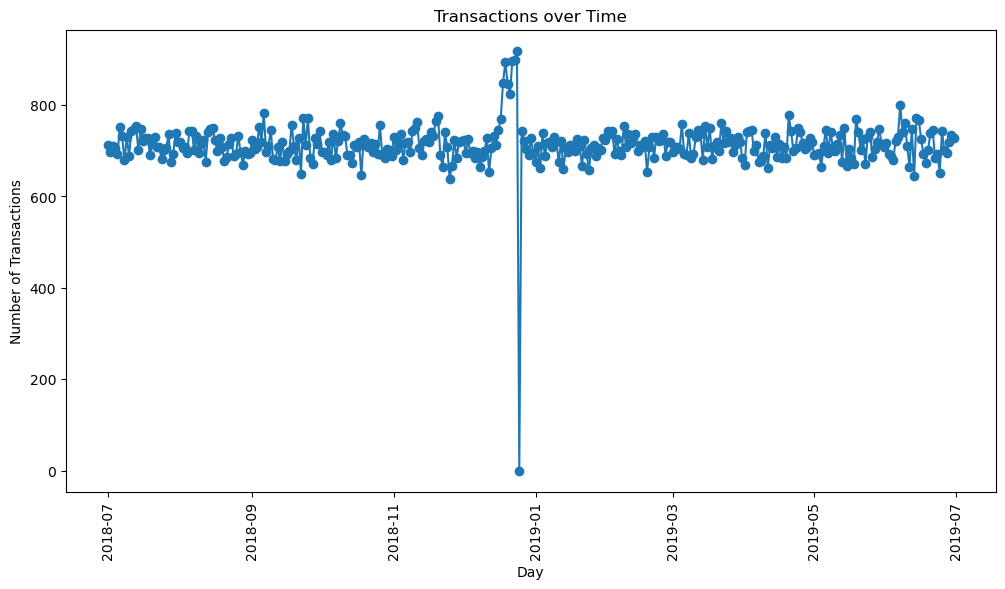

In [27]:
#plotting
transactions_by_day = pd.DataFrame({
    'DATE': full_date_range,
    'N': transaction_counts.values
})

# Plot transactions over time
plt.figure(figsize=(12, 6))
plt.plot(transactions_by_day['DATE'], transactions_by_day['N'], linestyle='-', marker='o')
plt.xlabel('Day')
plt.ylabel('Number of Transactions')
plt.title('Transactions over Time')
plt.xticks(rotation=90)

In [28]:
dec_dates = transactions_by_day[(transactions_by_day['DATE'] >= '2018-12-01') & (transactions_by_day['DATE'] <= '2018-12-31') ]
dec_dates

,DATE,N
153,2018-12-01,723
154,2018-12-02,694
155,2018-12-03,725
156,2018-12-04,695
157,2018-12-05,700
158,2018-12-06,683
159,2018-12-07,698
160,2018-12-08,664
161,2018-12-09,687
162,2018-12-10,699


(array([17866., 17870., 17874., 17878., 17882., 17886., 17890., 17894.,
        17897.]),
 [Text(17866.0, 0, '2018-12-01'),
  Text(17870.0, 0, '2018-12-05'),
  Text(17874.0, 0, '2018-12-09'),
  Text(17878.0, 0, '2018-12-13'),
  Text(17882.0, 0, '2018-12-17'),
  Text(17886.0, 0, '2018-12-21'),
  Text(17890.0, 0, '2018-12-25'),
  Text(17894.0, 0, '2018-12-29'),
  Text(17897.0, 0, '2019-01-01')])

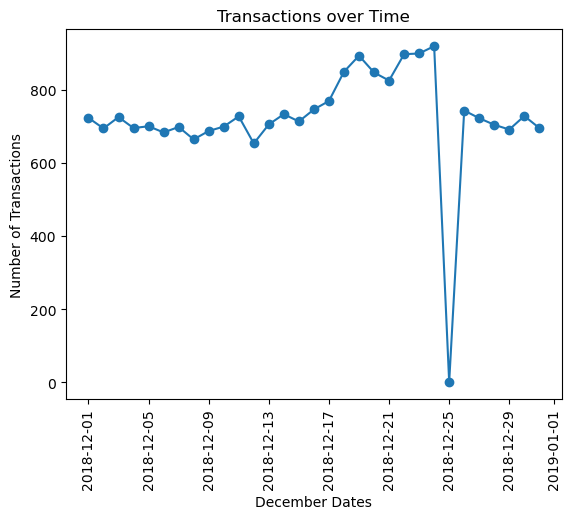

In [29]:
#from this we can say that on 2018-12-25 the shop is closed and there are no transactions.
plt.plot(dec_dates['DATE'], dec_dates['N'], linestyle='-', marker='o')
plt.xlabel('December Dates')
plt.ylabel('Number of Transactions')
plt.title('Transactions over Time')
plt.xticks(rotation=90)

In [30]:
#creating new variable pack_size from prod_name variable
df['PACK_SIZE']=df['PROD_NAME'].str.extract(r'(\d+[gG])', expand=False )

In [31]:
df['PACK_SIZE'] = df['PACK_SIZE'].str.lower() #some of the numbers have g and some of them have G converting all of them to lower

In [32]:
 df['PACK_SIZE'].value_counts().sort_index()

PACK_SIZE
110g    22387
125g     1454
134g    25102
135g     3257
150g    43131
160g     2970
165g    15297
170g    19983
175g    66390
180g     1468
190g     2995
200g     4473
210g     6272
220g     1564
250g     3169
270g     6285
300g    10590
330g    12540
380g     6416
70g      1507
90g      3008
Name: count, dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [Text(0, 0, '175g'),
  Text(1, 0, '150g'),
  Text(2, 0, '210g'),
  Text(3, 0, '160g'),
  Text(4, 0, '165g'),
  Text(5, 0, '110g'),
  Text(6, 0, '330g'),
  Text(7, 0, '170g'),
  Text(8, 0, '300g'),
  Text(9, 0, '180g'),
  Text(10, 0, '135g'),
  Text(11, 0, '70g'),
  Text(12, 0, '220g'),
  Text(13, 0, '190g'),
  Text(14, 0, '270g'),
  Text(15, 0, '90g'),
  Text(16, 0, '200g'),
  Text(17, 0, '134g'),
  Text(18, 0, '380g'),
  Text(19, 0, '125g'),
  Text(20, 0, '250g')])

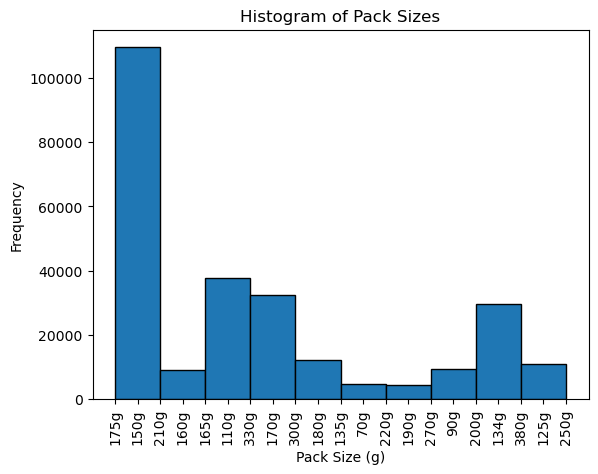

In [33]:
plt.hist(df['PACK_SIZE'], edgecolor='black')
plt.xlabel('Pack Size (g)')
plt.ylabel('Frequency')
plt.title('Histogram of Pack Sizes')
plt.xticks(rotation=90)

In [34]:
#creating brand_name variable from prod_name variable
df['BRAND_NAME'] = df['PROD_NAME'].str.split().str[0]

In [35]:
df['BRAND_NAME'].value_counts() #some of them have same brands but in shortcuts

BRAND_NAME
Kettle        41288
Smiths        28860
Pringles      25102
Doritos       24962
Thins         14075
RRD           11894
Infuzions     11057
WW            10320
Cobs           9693
Tostitos       9471
Twisties       9454
Tyrrells       6442
Grain          6272
Old            6239
Natural        6050
Red            5885
Cheezels       4603
CCs            4551
Dorito         3183
Infzns         3144
Smith          2963
Woolworths     2946
Cheetos        2927
Snbts          1576
Burger         1564
GrnWves        1468
Sunbites       1432
NCC            1419
French         1418
Name: count, dtype: int64

In [36]:
# Create a dictionary for mapping incorrect brand names to correct ones
brand_mapping = {
    "SNBTS": "Sunbites",
    "INFZNS": "Infuzions",
    "WW": "Woolworths",
    "Smith": "Smiths",
    "NCC": "Natural",
    "Dorito": "Doritos",
    "Grain": "GRNWVES",
    "Smith": "Smiths",
    "Infzns": "Infuzions",
    "Red": "RRD",
    "Snbts" : "Sunbites"
    
}

In [37]:
df['BRAND_NAME'] = df['BRAND_NAME'].replace(brand_mapping)

# Display the value counts
brand_counts = df['BRAND_NAME'].value_counts()
brand_counts

BRAND_NAME
Kettle        41288
Smiths        31823
Doritos       28145
Pringles      25102
RRD           17779
Infuzions     14201
Thins         14075
Woolworths    13266
Cobs           9693
Tostitos       9471
Twisties       9454
Natural        7469
Tyrrells       6442
GRNWVES        6272
Old            6239
Cheezels       4603
CCs            4551
Sunbites       3008
Cheetos        2927
Burger         1564
GrnWves        1468
French         1418
Name: count, dtype: int64

In [38]:
df['BRAND_NAME'].unique()

array(['Natural', 'RRD', 'GRNWVES', 'Woolworths', 'Cheetos', 'Infuzions',
       'Doritos', 'Old', 'GrnWves', 'Smiths', 'Kettle', 'CCs', 'Tostitos',
       'Cobs', 'Burger', 'Thins', 'Tyrrells', 'Cheezels', 'Twisties',
       'Sunbites', 'Pringles', 'French'], dtype=object)

In [39]:
df

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND_NAME
0,1000,YOUNG SINGLES/COUPLES,Premium,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175g,Natural
1,1002,YOUNG SINGLES/COUPLES,Mainstream,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150g,RRD
2,1003,YOUNG FAMILIES,Budget,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210g,GRNWVES
3,1003,YOUNG FAMILIES,Budget,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175g,Natural
4,1004,OLDER SINGLES/COUPLES,Mainstream,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160g,Woolworths
...,...,...,...,...,...,...,...,...,...,...,...,...
264831,2370701,YOUNG FAMILIES,Mainstream,2018-12-08,88,240378,24,Grain Waves Sweet Chilli 210g,2,7.2,210g,GRNWVES
264832,2370751,YOUNG FAMILIES,Premium,2018-10-01,88,240394,60,Kettle Tortilla ChpsFeta&Garlic 150g,2,9.2,150g,Kettle
264833,2370961,OLDER FAMILIES,Budget,2018-10-24,88,240480,70,Tyrrells Crisps Lightly Salted 165g,2,8.4,165g,Tyrrells
264834,2370961,OLDER FAMILIES,Budget,2018-10-27,88,240481,65,Old El Paso Salsa Dip Chnky Tom Ht300g,2,10.2,300g,Old


In [40]:
df.to_csv("df.csv", index=False) #writing to a csv file

In [41]:
#data Analysis
sales_summary = df.groupby(['PREMIUM_CUSTOMER','LIFESTAGE'])['TOT_SALES'].sum().reset_index()
sales_summary_sorted = sales_summary.sort_values(by='TOT_SALES', ascending=False)
print(sales_summary_sorted)

#Budget     OLDER FAMILIES  165483.25,   Mainstream   YOUNG SINGLES/COUPLES  154609.90
#  Mainstream   RETIREES  152780.25 have high sales

   PREMIUM_CUSTOMER               LIFESTAGE  TOT_SALES
2            Budget          OLDER FAMILIES  165483.25
13       Mainstream   YOUNG SINGLES/COUPLES  154609.90
11       Mainstream                RETIREES  152780.25
5            Budget          YOUNG FAMILIES  136965.65
3            Budget   OLDER SINGLES/COUPLES  134496.10
10       Mainstream   OLDER SINGLES/COUPLES  130946.40
17          Premium   OLDER SINGLES/COUPLES  129746.15
4            Budget                RETIREES  111241.60
9        Mainstream          OLDER FAMILIES  101929.05
18          Premium                RETIREES   95726.35
12       Mainstream          YOUNG FAMILIES   91176.85
7        Mainstream  MIDAGE SINGLES/COUPLES   89032.95
19          Premium          YOUNG FAMILIES   82446.90
16          Premium          OLDER FAMILIES   79249.00
6            Budget   YOUNG SINGLES/COUPLES   60013.00
14          Premium  MIDAGE SINGLES/COUPLES   57383.85
20          Premium   YOUNG SINGLES/COUPLES   41012.10
0         

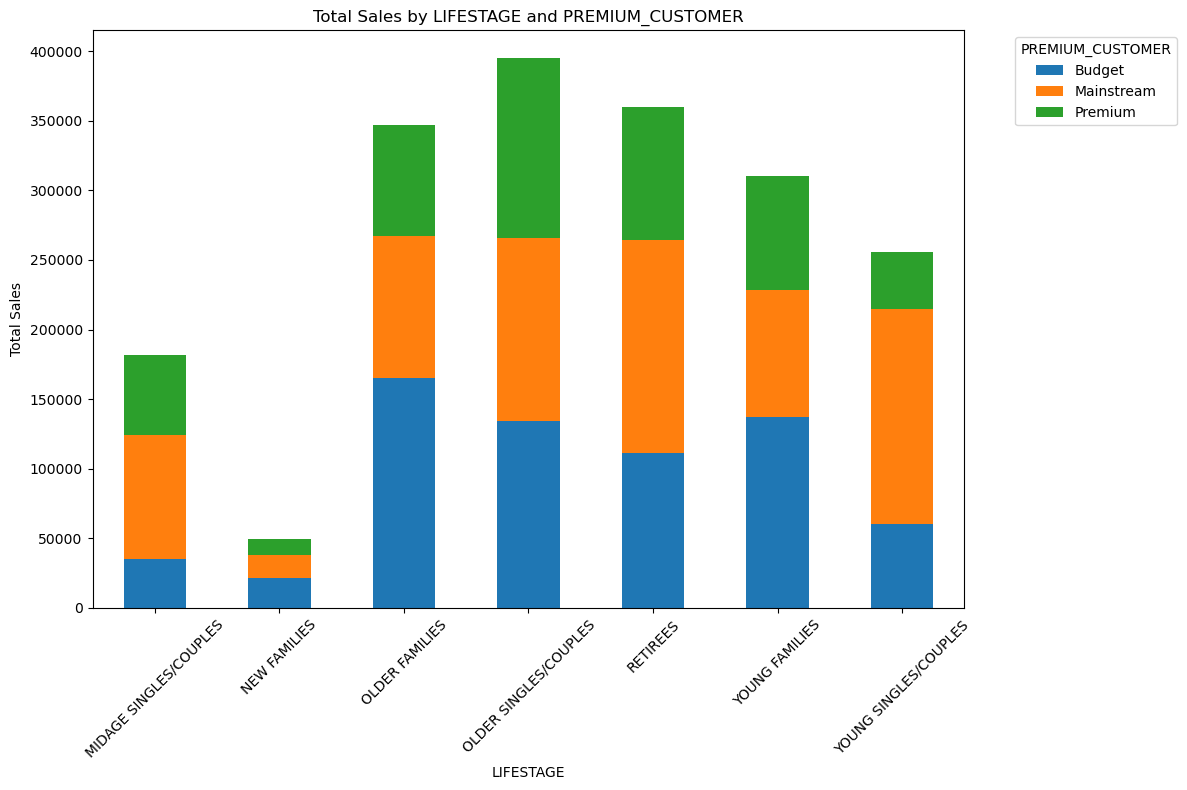

In [42]:
sales_pivot = pd.pivot_table(sales_summary, values='TOT_SALES', index='LIFESTAGE', columns='PREMIUM_CUSTOMER')

# Plotting the results
sales_pivot.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Total Sales by LIFESTAGE and PREMIUM_CUSTOMER')
plt.xlabel('LIFESTAGE')
plt.ylabel('Total Sales')
plt.legend(title='PREMIUM_CUSTOMER', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [43]:
#let's see if the high sales are because of number of customers.
customer_count = df.groupby(['PREMIUM_CUSTOMER','LIFESTAGE'])['LYLTY_CARD_NBR'].nunique().reset_index()
customer_count_sorted = customer_count.sort_values(by = 'LYLTY_CARD_NBR' , ascending = False)
customer_count_sorted

#There are more Mainstream - young singles/couples and Mainstream - retirees who buy
#chips. This contributes to there being more sales to these customer segments but
#his is not a major driver for the Budget - Older families segment.

,PREMIUM_CUSTOMER,LIFESTAGE,LYLTY_CARD_NBR
13,Mainstream,YOUNG SINGLES/COUPLES,8040
11,Mainstream,RETIREES,6451
3,Budget,OLDER SINGLES/COUPLES,4909
10,Mainstream,OLDER SINGLES/COUPLES,4906
17,Premium,OLDER SINGLES/COUPLES,4729
2,Budget,OLDER FAMILIES,4660
4,Budget,RETIREES,4440
5,Budget,YOUNG FAMILIES,3998
18,Premium,RETIREES,3856
6,Budget,YOUNG SINGLES/COUPLES,3744


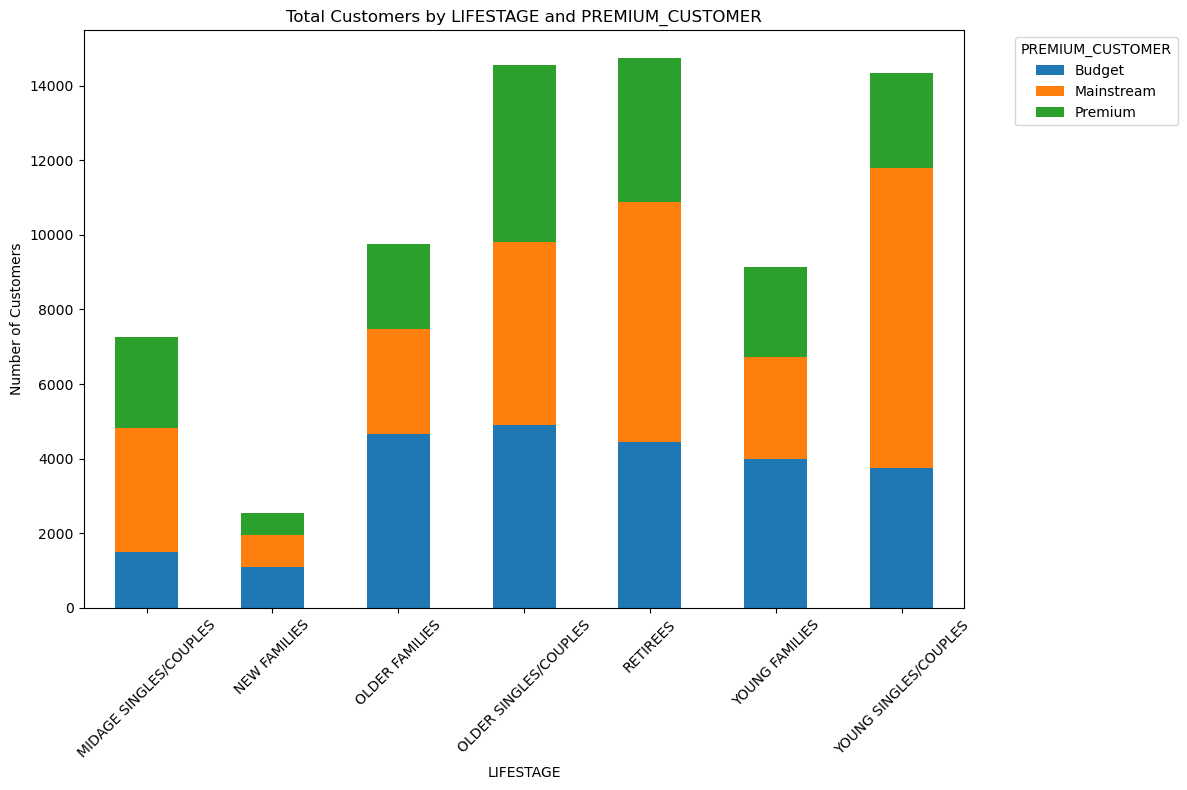

In [44]:
sales_pivot = pd.pivot_table(customer_count_sorted, values='LYLTY_CARD_NBR', index='LIFESTAGE', columns='PREMIUM_CUSTOMER')

# Plotting the results
sales_pivot.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Total Customers by LIFESTAGE and PREMIUM_CUSTOMER')
plt.xlabel('LIFESTAGE')
plt.ylabel('Number of Customers')
plt.legend(title='PREMIUM_CUSTOMER', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [45]:
#let's see if there are high number of chips sold 
chips_sold = df.groupby(['PREMIUM_CUSTOMER','LIFESTAGE'])['PROD_QTY'].mean().reset_index()
chips_sold_sorted = chips_sold.sort_values(by = 'PROD_QTY' , ascending = False)
chips_sold_sorted

#Older families and young families in general buy more chips per customer.

,PREMIUM_CUSTOMER,LIFESTAGE,PROD_QTY
9,Mainstream,OLDER FAMILIES,1.949038
2,Budget,OLDER FAMILIES,1.945696
16,Premium,OLDER FAMILIES,1.944434
5,Budget,YOUNG FAMILIES,1.941008
12,Mainstream,YOUNG FAMILIES,1.940147
19,Premium,YOUNG FAMILIES,1.937621
17,Premium,OLDER SINGLES/COUPLES,1.914032
3,Budget,OLDER SINGLES/COUPLES,1.913694
7,Mainstream,MIDAGE SINGLES/COUPLES,1.911850
10,Mainstream,OLDER SINGLES/COUPLES,1.910774


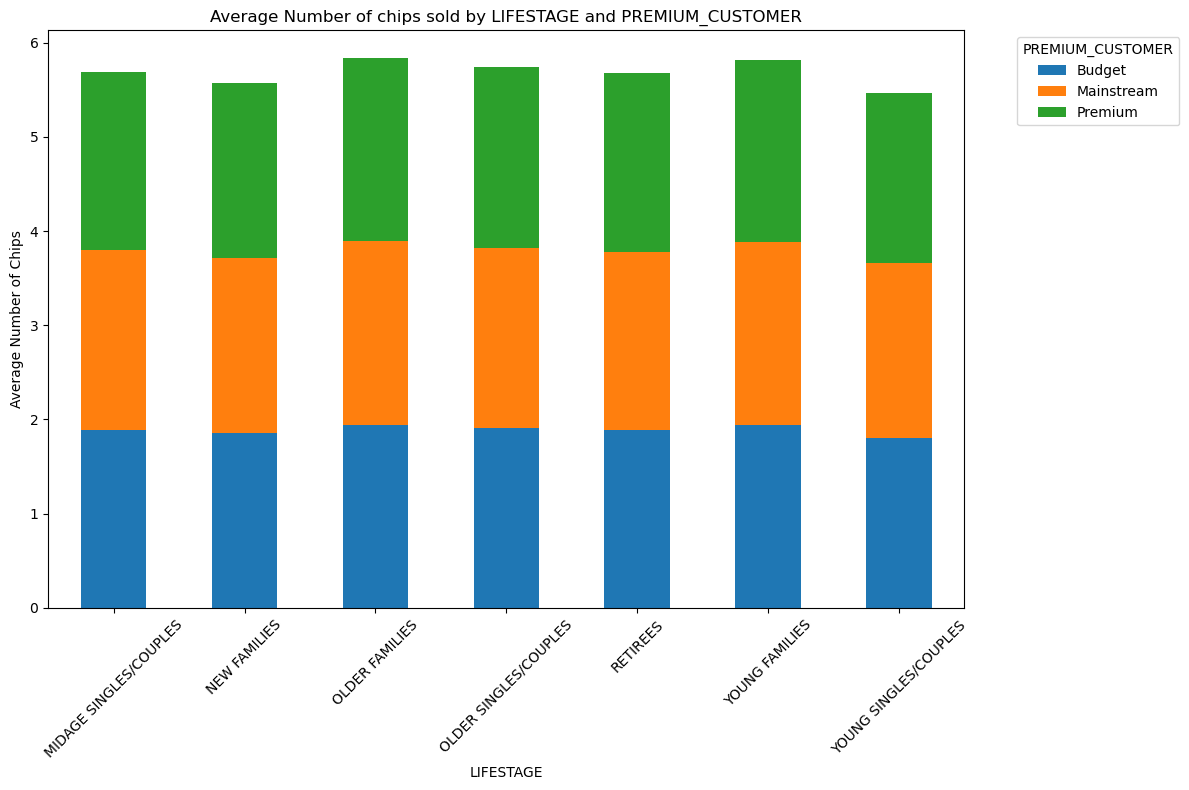

In [46]:
sales_pivot = pd.pivot_table(chips_sold_sorted, values='PROD_QTY', index='LIFESTAGE', columns='PREMIUM_CUSTOMER')

# Plotting the results
sales_pivot.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Average Number of chips sold by LIFESTAGE and PREMIUM_CUSTOMER')
plt.xlabel('LIFESTAGE')
plt.ylabel('Average Number of Chips')
plt.legend(title='PREMIUM_CUSTOMER', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [47]:
df['PRICE_PER_UNIT'] = df['TOT_SALES'] / df['PROD_QTY']  # Assuming TOTAL_SALES is total sales for each transaction
avg_price_per_unit = df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PRICE_PER_UNIT'].mean().reset_index()
avg_price_per_unit.sort_values(by = 'PRICE_PER_UNIT' , ascending = False)

#Mainstream midage and young singles and couples are more willing to pay more per
#packet of chips compared to their budget and premium counterparts.

,LIFESTAGE,PREMIUM_CUSTOMER,PRICE_PER_UNIT
19,YOUNG SINGLES/COUPLES,Mainstream,4.065686
1,MIDAGE SINGLES/COUPLES,Mainstream,3.993072
12,RETIREES,Budget,3.919985
4,NEW FAMILIES,Mainstream,3.918414
3,NEW FAMILIES,Budget,3.916746
14,RETIREES,Premium,3.914250
11,OLDER SINGLES/COUPLES,Premium,3.885601
9,OLDER SINGLES/COUPLES,Budget,3.874856
5,NEW FAMILIES,Premium,3.872201
13,RETIREES,Mainstream,3.832221


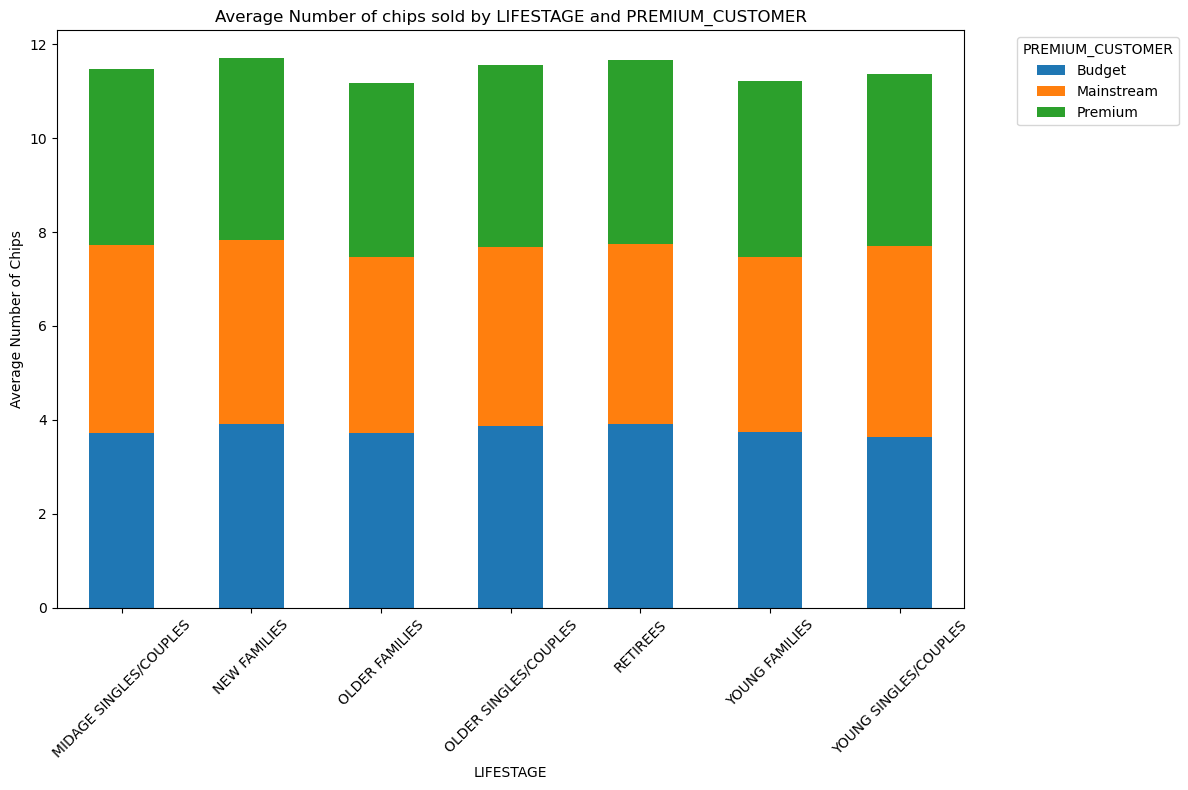

In [48]:
# Plotting
sales_pivot = pd.pivot_table(avg_price_per_unit, values='PRICE_PER_UNIT', index='LIFESTAGE', columns='PREMIUM_CUSTOMER')

sales_pivot.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Average Number of chips sold by LIFESTAGE and PREMIUM_CUSTOMER')
plt.xlabel('LIFESTAGE')
plt.ylabel('Average Number of Chips')
plt.legend(title='PREMIUM_CUSTOMER', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [49]:
#Performing an independent t-test between mainstream vs premium and budget midage and
# young singles and couples to know if there is a significant difference between them.

# Filter data for the specified segments
mainstream_segment = df[(df['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES'])) & (df['PREMIUM_CUSTOMER'] == 'Mainstream')]['PRICE_PER_UNIT']
other_segments = df[(df['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES'])) & (df['PREMIUM_CUSTOMER'].isin(['Budget', 'Premium']))]['PRICE_PER_UNIT']

# Perform independent t-test using statsmodels
tstat, pval, _ = sm.stats.ttest_ind(mainstream_segment, other_segments, alternative='larger')

# Print t-test results
print(f"T-test results: p-value = {pval:.2e}")

# Interpretation based on p-value
if pval < 0.05:
    print("The unit price for mainstream, young and mid-age singles and couples is significantly higher than that of budget or premium, young and midage singles and couples.")
else:
    print("There is no significant difference in unit price between mainstream, young and mid-age singles and couples compared to budget or premium, young and midage singles and couples.")


T-test results: p-value = 0.00e+00
The unit price for mainstream, young and mid-age singles and couples is significantly higher than that of budget or premium, young and midage singles and couples.


In [50]:

# Segment the data
segment1 = df[(df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (df['PREMIUM_CUSTOMER'] == 'Mainstream')]
other = df[~((df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (df['PREMIUM_CUSTOMER'] == 'Mainstream'))]

# Calculate total quantity of products sold
quantity_segment1 = segment1['PROD_QTY'].sum()
quantity_other = other['PROD_QTY'].sum()

# Calculate quantity sold by brand for each segment
quantity_segment1_by_brand = segment1.groupby('BRAND_NAME')['PROD_QTY'].sum().reset_index()
quantity_segment1_by_brand['targetSegment'] = quantity_segment1_by_brand['PROD_QTY'] / quantity_segment1

quantity_other_by_brand = other.groupby('BRAND_NAME')['PROD_QTY'].sum().reset_index()
quantity_other_by_brand['other'] = quantity_other_by_brand['PROD_QTY'] / quantity_other

# Merge and calculate brand affinity
brand_proportions = pd.merge(quantity_segment1_by_brand[['BRAND_NAME', 'targetSegment']],
                             quantity_other_by_brand[['BRAND_NAME', 'other']],
                             on='BRAND_NAME')
brand_proportions['affinityToBrand'] = brand_proportions['targetSegment'] / brand_proportions['other']

# Sort by affinity to brand
brand_proportions_sorted = brand_proportions.sort_values(by='affinityToBrand', ascending=False)

brand_proportions_sorted


,BRAND_NAME,targetSegment,other,affinityToBrand
20,Tyrrells,0.030119,0.024353,1.236803
19,Twisties,0.044085,0.035901,1.227965
10,Kettle,0.188990,0.156920,1.204376
18,Tostitos,0.043348,0.035997,1.204191
13,Pringles,0.113995,0.095387,1.195084
12,Old,0.027800,0.023709,1.172591
5,Doritos,0.125089,0.107123,1.167713
7,GRNWVES,0.027800,0.023811,1.167538
4,Cobs,0.042610,0.037012,1.151229
9,Infuzions,0.061741,0.054089,1.141471


In [51]:
segment1 = df[(df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (df['PREMIUM_CUSTOMER'] == 'Mainstream')]
other = df[~((df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (df['PREMIUM_CUSTOMER'] == 'Mainstream'))]

# Calculate total quantity of products sold
quantity_segment1 = segment1['PROD_QTY'].sum()
quantity_other = other['PROD_QTY'].sum()

# Calculate quantity sold by pack size for each segment
quantity_segment1_by_pack = segment1.groupby('PACK_SIZE')['PROD_QTY'].sum().reset_index()
quantity_segment1_by_pack['targetSegment'] = quantity_segment1_by_pack['PROD_QTY'] / quantity_segment1

quantity_other_by_pack = other.groupby('PACK_SIZE')['PROD_QTY'].sum().reset_index()
quantity_other_by_pack['other'] = quantity_other_by_pack['PROD_QTY'] / quantity_other

# Merge and calculate pack size preference
pack_proportions = pd.merge(quantity_segment1_by_pack[['PACK_SIZE', 'targetSegment']],
                            quantity_other_by_pack[['PACK_SIZE', 'other']],
                            on='PACK_SIZE')
pack_proportions['preference'] = pack_proportions['targetSegment'] / pack_proportions['other']

# Sort by preference
pack_proportions_sorted = pack_proportions.sort_values(by='preference', ascending=False)
pack_proportions_sorted 

,PACK_SIZE,targetSegment,other,preference
15,270g,0.030383,0.023787,1.277280
18,380g,0.030699,0.024250,1.265943
17,330g,0.058500,0.047546,1.230379
2,134g,0.113995,0.095387,1.195084
0,110g,0.101452,0.085109,1.192030
12,210g,0.027800,0.023811,1.167538
3,135g,0.014098,0.012394,1.137519
14,250g,0.013703,0.012114,1.131130
7,170g,0.077103,0.076763,1.004442
8,175g,0.243406,0.255926,0.951078
